## IDS/ACM/CS 158: Fundamentals of Statistical Learning
### PS4, Problem 5: Linear and Quadratic Discriminant Analysis
> Name: Li, Michael
 
> Email address: mlli@caltech.edu

Notes:
Please use python 3.6

You are required to properly comment and organize your code.

* Helper functions (add/remove part label according to the specific question requirements)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def lda(data):
    """
    data - a matrix where each row corresponds to the 
           p predictors in the first p columns and
           the observed output y in the final column
    
    returns the coefficients for the lda functions
    """
    g1 = np.array([observation[:-1] for observation in data if observation[-1] == 1])
    g0 = np.array([observation[:-1] for observation in data if observation[-1] == 0])
    
    # calculate pi, mu, and pooled variance for each class
    pi1 = len(g1) / len(data)
    pi0 = len(g0) / len(data)
    
    mu1 = np.mean(g1, axis=0)
    mu0 = np.mean(g0, axis=0)
    
    pooled_var = (1 / (len(data) - 2)) * (np.matmul((g1-mu1).transpose(), g1-mu1) + np.matmul((g0-mu0).transpose(), g0-mu0))
    
    # get coefficients for each delta function for LDA
    delta_0_term_1 = np.matmul(mu0.transpose(), np.linalg.inv(pooled_var))
    delta_0_term_2 = (1/2) * np.matmul(np.matmul(mu0.transpose(), np.linalg.inv(pooled_var)), mu0)
    delta_0_term_3 = np.log(pi0)
    
    delta_1_term_1 = np.matmul(mu1.transpose(), np.linalg.inv(pooled_var))
    delta_1_term_2 = (1/2) * np.matmul(np.matmul(mu1.transpose(), np.linalg.inv(pooled_var)), mu1)
    delta_1_term_3 = np.log(pi1)
    
    return (delta_0_term_1, delta_0_term_2, delta_0_term_3), (delta_1_term_1, delta_1_term_2, delta_1_term_3)

def qda(data):
    """
    data - a matrix where each row corresponds to the 
           p predictors in the first p columns and
           the observed output y in the final column
    
    returns the coefficients for the qda functions
    """
    g1 = np.array([observation[:-1] for observation in data if observation[-1] == 1])
    g0 = np.array([observation[:-1] for observation in data if observation[-1] == 0])
    
    # calculate pi, mu, and variance for each class
    pi1 = len(g1) / len(data)
    pi0 = len(g0) / len(data)
    
    mu1 = np.mean(g1, axis=0)
    mu0 = np.mean(g0, axis=0)
    
    var1 = (1 / (len(g1)-1)) * (np.matmul((g1-mu1).transpose(), g1-mu1))
    var0 = (1 / (len(g0)-1)) * (np.matmul((g0-mu0).transpose(), g0-mu0))
    
    # get coefficients for each delta function for QDA
    delta_0_term_2 = -1/2 * np.log(np.linalg.det(var0))
    delta_0_term_3 = np.log(pi0)
    
    delta_1_term_2 = -1/2 * np.log(np.linalg.det(var1))
    delta_1_term_3 = np.log(pi1)
    
    return (mu0, np.linalg.inv(var0), delta_0_term_2+delta_0_term_3), (mu1, np.linalg.inv(var1), delta_1_term_2+delta_1_term_3)


def find_linear_boundary(delta_0, delta_1):
    """
    delta_0 - the coefficients for delta_0 LDA function
    delta_1 - the coefficients for delta_1 LDA function
    
    returns the slope and bias for the linear boundary between the two classes
    """
    delta_0_term_1, delta_0_term_2, delta_0_term_3 = delta_0
    delta_1_term_1, delta_1_term_2, delta_1_term_3 = delta_1
    
    bias = -delta_1_term_2+delta_1_term_3+delta_0_term_2-delta_0_term_3
    mat = delta_0_term_1 - delta_1_term_1
    
    return -mat[0]/mat[1], bias/mat[1]

def find_quad_boundary(data, delta_0, delta_1):
    """
    data - a matrix where each row corresponds to the 
           p predictors in the first p columns and
           the observed output y in the final column
    delta_0 - the coefficients for delta_0 QDA function
    delta_1 - the coefficients for delta_1 QDA function
    
    returns the points that make up the boundary for the classes using QDA
    """
    mu0, inverse_var0, bias0 = delta_0
    mu1, inverse_var1, bias1 = delta_1
    
    # define grid
    x0s = np.arange(min(data[:,0]), max(data[:,0]), .01)
    x1s = np.arange(min(data[:,1]), max(data[:,1]), .01)
    
    tol = .01
    xs = []
    ys = []
    
    # check each point in grid and see if delta functions are close enough
    for x0 in x0s:
        for x1 in x1s:
            x = np.array([x0, x1])
            
            delta_0_term_1 = -1/2 * np.matmul(np.matmul((x-mu0).transpose(), inverse_var0), x-mu0)
            delta_1_term_1 = -1/2 * np.matmul(np.matmul((x-mu1).transpose(), inverse_var1), x-mu1)
            
            delta_0 = delta_0_term_1 + bias0
            delta_1 = delta_1_term_1 + bias1
            
            # if so we add those points to our list of points for the boundary
            if np.abs(delta_0 - delta_1) < tol:
                xs.append(x0)
                ys.append(x1)
    
    return xs, ys

def lda_predict(delta_0, delta_1, x, alpha=1/2):
    """
    delta_0 - the coefficients for delta_0 LDA function
    delta_1 - the coefficients for delta_1 LDA function
    alpha - classification threshold
    
    returns the prediction using LDA functions
    """
    delta_0_term_1, delta_0_term_2, delta_0_term_3 = delta_0
    delta_1_term_1, delta_1_term_2, delta_1_term_3 = delta_1
    
    delta_0 = np.matmul(delta_0_term_1, x) - delta_0_term_2 + delta_0_term_3
    delta_1 = np.matmul(delta_1_term_1, x) - delta_1_term_2 + delta_1_term_3
    
    if alpha == 0:
        return 0
    elif alpha == 1:
        return 1
    else:
        # classification rule derived in part c 
        return 0 if delta_0 > delta_1 + np.log(alpha / (1-alpha)) else 1    

def qda_predict(delta_0, delta_1, x, alpha=1/2):
    """
    delta_0 - the coefficients for delta_0 QDA function
    delta_1 - the coefficients for delta_1 QDA function
    alpha - classification threshold
    
    returns the prediction using QDA functions
    """
    mu0, inverse_var0, bias0 = delta_0
    mu1, inverse_var1, bias1 = delta_1
    
    delta_0_term_1 = -1/2 * np.matmul(np.matmul((x-mu0).transpose(), inverse_var0), x-mu0)
    delta_1_term_1 = -1/2 * np.matmul(np.matmul((x-mu1).transpose(), inverse_var1), x-mu1)

    delta_0 = delta_0_term_1 + bias0
    delta_1 = delta_1_term_1 + bias1
    
    if alpha == 0:
        return 0
    elif alpha == 1:
        return 1
    else:
        # classification rule derived in part c
        return 0 if delta_0 > delta_1 + np.log(alpha / (1-alpha)) else 1

def class_errors(real, preds):
    """
    real - list of real classes for each observation
    preds - list of predicted classes for each observation
    
    returns test errors on g_0 and g_1
    """
    n_10 = 0
    n_11 = 0
    n_00 = 0
    n_01 = 0

    for i in range(len(preds)):
        if real[i] == 1:
            if preds[i] == 1:
                n_11 += 1
            else:
                n_01 += 1
        else:
            if preds[i] == 1:
                n_10 += 1
            else:
                n_00 += 1
                
    return n_10 / (n_00 + n_10), n_01 / (n_11 + n_01)
    

* <b>Part A</b>

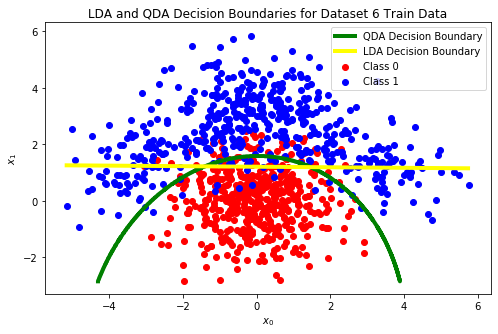

In [2]:
train_data = np.genfromtxt('dataset6_train.csv', delimiter=',', skip_header=1)
test_data = np.genfromtxt('dataset6_test.csv', delimiter=',', skip_header=1)

# find the lda coefficients and decision boundary
lda_delta_0, lda_delta_1 = lda(train_data)
coeffs = find_linear_boundary(lda_delta_0, lda_delta_1)
lda_boundary_x = np.arange(min(train_data[:,0]), max(train_data[:,0]), .1)
lda_boundary_y = [coeffs[0]*i+coeffs[1] for i in lda_boundary_x]

# find the qda coefficients and decision boundary
qda_delta_0, qda_delta_1 = qda(train_data)
qda_boundary_x, qda_boundary_y = find_quad_boundary(train_data, qda_delta_0, qda_delta_1)

# get the points of the training data
train_1s = np.array([data[:-1] for data in train_data if data[-1] == 1])
train_0s = np.array([data[:-1] for data in train_data if data[-1] == 0])

plt.rcParams['figure.figsize'] = [8, 5]
plt.title('LDA and QDA Decision Boundaries for Dataset 6 Train Data')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.scatter(train_0s[:,0], train_0s[:,1], c='red', label='Class 0')
plt.scatter(train_1s[:,0], train_1s[:,1], c='blue', label='Class 1')
plt.plot(qda_boundary_x, qda_boundary_y, linewidth='4', c='green', label='QDA Decision Boundary')
plt.plot(lda_boundary_x, lda_boundary_y, linewidth='4', c='yellow', label='LDA Decision Boundary')
plt.legend()
plt.show()

* <b>Part B</b>

In [3]:
# make predictions with the two models and check errors
lda_test_preds = [lda_predict(lda_delta_0, lda_delta_1, x) for x in test_data[:,:-1]]
qda_test_preds = [qda_predict(qda_delta_0, qda_delta_1, x) for x in test_data[:,:-1]]

lda_average_err = sum(lda_test_preds != test_data[:,-1]) / len(lda_test_preds)
qda_average_err = sum(qda_test_preds != test_data[:,-1]) / len(qda_test_preds)
lda_average_err, qda_average_err

(0.127, 0.059)

We see here from the errors that Quadratic Discriminant Analysis is more eficient on this particular dataset.

* <b>Part C</b>

$$ P(G = G_0| X =x) > \alpha \implies P(G = G_0 | X =x) = \alpha \text{ and } P(G = G_0 | X =x) = 1 - \alpha$$ \
$$ P(G = G_0 | X =x) = \frac{\alpha}{1-\alpha} P(G = G_1 | X =x)$$ \
$$ \text{log}(P(G = G_0 | X =x)) = \text{log}(\frac{\alpha}{1-\alpha} P(G = G_1 | X =x))$$ \
$$ \text{log}(\pi_0 f_0(x)) - \text{log}(\sum_{s=1}^k \pi_sf_s(x)) = \text{log}(\frac{\alpha}{1-\alpha}) + \text{log}(\pi_1 f_1(x)) - \text{log}(\sum_{s=1}^k \pi_sf_s(x))$$ 
$$ \text{log}(\pi_0) + \text{log}(\frac{1}{(2\pi)^{p/2}|\Sigma|^\frac{1}{2}}) + \text{log}(\text{exp}[\frac{-1}{2}(x-\mu_0)^T\Sigma^{-1}(x-\mu_0)]) = \text{log}(\frac{\alpha}{1-\alpha}) + \text{log}(\pi_1) + \text{log}(\frac{1}{(2\pi)^{p/2}|\Sigma|^\frac{1}{2}}) + \text{log}(\text{exp}[\frac{-1}{2}(x-\mu_1)^T\Sigma^{-1}(x-\mu_1)])$$
$$ \text{log}(\pi_0) + \text{log}(\text{exp}[\frac{-1}{2}(x-\mu_0)^T\Sigma^{-1}(x-\mu_0)]) = \text{log}(\frac{\alpha}{1-\alpha}) + \text{log}(\pi_1) + \text{log}(\text{exp}[\frac{-1}{2}(x-\mu_1)^T\Sigma^{-1}(x-\mu_1)])$$


From lecture 12 page 69, we know that we are able to derive $\delta_0(x)$ and $\delta_1(x)$ from here which gives us our definition of each delta so we can substitute that in here. By symmetry, we can say the same rule applies for QDA. Thus, our new decision boundary is found by this

$$ \delta_0(x) = \delta_1(x) + \text{log}(\frac{\alpha}{1-\alpha})$$

So this gives us our new decision boundary and our new classification rule becomes 
$$ \delta_0(x) > \delta_1(x) + \text{log}(\frac{\alpha}{1-\alpha}) $$ 
if this is true then x is class $G_0$ otherwise it is $G_1$

In [4]:
alphas = np.arange(0, 1.01, .01)
lda_err_0s = []
lda_one_minus_err_1s = []

qda_err_0s = []
qda_one_minus_err_1s = []

# for all the classification thresholds
for a in alphas:
    # make our predictions and find the class errors and add to our list of points to plot
    lda_test_preds = [lda_predict(lda_delta_0, lda_delta_1, x, a) for x in test_data[:,:-1]]
    qda_test_preds = [qda_predict(qda_delta_0, qda_delta_1, x, a) for x in test_data[:,:-1]]
    
    lda_errs = class_errors(test_data[:,-1], lda_test_preds)
    qda_errs = class_errors(test_data[:,-1], qda_test_preds)
    
    lda_err_0s.append(lda_errs[0])
    lda_one_minus_err_1s.append(1-lda_errs[1])
    
    qda_err_0s.append(qda_errs[0])
    qda_one_minus_err_1s.append(1-qda_errs[1])
    

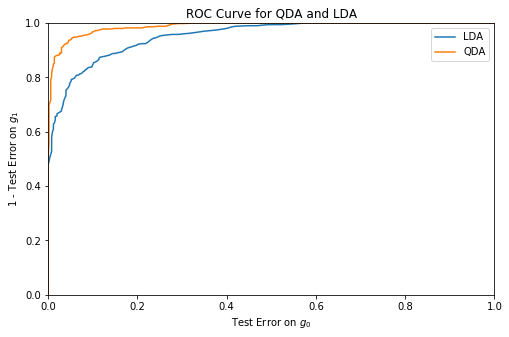

In [5]:
plt.plot(lda_err_0s, lda_one_minus_err_1s, label='LDA')
plt.plot(qda_err_0s, qda_one_minus_err_1s, label='QDA')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('ROC Curve for QDA and LDA')
plt.xlabel('Test Error on $g_0$')
plt.ylabel('1 - Test Error on $g_1$')
plt.legend()
plt.show()

QDA is still more efficient based on the ROC curves.